<a href="https://colab.research.google.com/github/mattkingros/COMP551Project4/blob/main/Attention_maps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 Google LLC.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax_augreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## How to train your ViT? Data, Augmentation, and Regularization in Vision Transformers

Model repository published with the paper

[**How to train your ViT? Data, Augmentation, and Regularization in Vision
Transformers**](https://arxiv.org/abs/TODO)

This Colab shows how to
[find checkpoints](#scrollTo=F4SLGDtFxlsC)
in the repository, how to
[select and load a model](#scrollTo=wh_SLkQtQ6K4)
form the repository and use it for inference
([also with PyTorch](#scrollTo=1nMyWmDycpAo)),
and how to
[fine-tune on a dataset](#scrollTo=iAruT3YOxqB6).

For more details, please refer to the repository:

https://github.com/google-research/vision_transformer/

Note that this Colab directly uses the unmodified code from the repository. If
you want to modify the modules and persist your changes, you can do all that
using free GPUs and TPUs without leaving the Colab environment - see

https://colab.research.google.com/github/google-research/vision_transformer/blob/master/vit_jax.ipynb

### Imports

In [ ]:
# Fetch vision_transformer repository.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer


Cloning into 'vision_transformer'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 37 (delta 4), reused 29 (delta 4), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
# Install dependencies.
!pip install -qr vision_transformer/vit_jax/requirements.txt

     |████████████████████████████████| 65 kB 2.1 MB/s 
     |████████████████████████████████| 77 kB 6.0 MB/s 
     |████████████████████████████████| 207 kB 36.8 MB/s 
     |████████████████████████████████| 88 kB 7.5 MB/s 
     |████████████████████████████████| 179.8 MB 78 kB/s 
     |████████████████████████████████| 126 kB 47.5 MB/s 


In [ ]:
# Import files from repository.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import models
from vit_jax import train
from vit_jax.configs import augreg as augreg_config
from vit_jax.configs import models as models_config

In [ ]:
# Connect to TPUs if runtime type is of type TPU.

import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  # Otherwise print information about GPU.
  !nvidia-smi

Mon Dec 13 15:54:04 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Some more imports used in this Colab.

import glob
import os
import random
import shutil
import time

from absl import logging
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

pd.options.display.max_colwidth = None
logging.set_verbosity(logging.INFO)  # Shows logs during training.

### Explore checkpoints

This section contains shows how to use the `index.csv` table for model
selection.

See
[`vit_jax.checkpoint.get_augreg_df()`](https://github.com/google-research/vision_transformer/blob/ed1491238f5ff6099cca81087c575a215281ed14/vit_jax/checkpoint.py#L181-L228)
for a detailed description of the individual columns

In [ ]:
# Load master table from Cloud.
with tf.io.gfile.GFile('gs://vit_models/augreg/index.csv') as f:
  df = pd.read_csv(f)

In [ ]:
# This is a pretty large table with lots of columns:
print(f'loaded {len(df):,} rows')
df.columns

loaded 51,509 rows


Index(['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val',
       'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps',
       'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params',
       'infer_samples_per_sec', 'filename', 'adapt_filename'],
      dtype='object')

In [ ]:
# Number of distinct checkpoints
len(tf.io.gfile.glob('gs://vit_models/augreg/*.npz'))

52268

In [ ]:
# Any column prefixed with "adapt_" pertains to the fine-tuned checkpoints.
# Any column without that prefix pertains to the pre-trained checkpoints.
len(set(df.filename)), len(set(df.adapt_filename))

(759, 51509)

In [ ]:
df.name.unique()

array(['Ti/16', 'S/32', 'B/16', 'L/16', 'R50+L/32', 'R26+S/32', 'S/16',
       'B/32', 'R+Ti/16', 'B/8'], dtype=object)

In [ ]:
# Upstream AugReg parameters (section 3.3):
(
df.groupby(['ds', 'name', 'wd', 'do', 'sd', 'aug']).filename
  .count().unstack().unstack().unstack()
  .dropna(1, 'all').fillna(0).astype(int)
  .iloc[:7]  # Just show beginning of a long table.
)

aug              light0     light1     medium1  ... none strong1     strong2    
sd                  0.0 0.1    0.0 0.1     0.0  ...  0.1     0.0 0.1     0.0 0.1
do                  0.0 0.1    0.0 0.1     0.0  ...  0.1     0.0 0.1     0.0 0.1
ds  name    wd                                  ...                             
i1k B/16    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    B/32    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    L/16    0.03     68  68     68  68      68  ...   68      68  68      68  68
            0.10     68  68     68  68      68  ...   68      68  68      68  68
    R+Ti/16 0.03     68  68     68  68      68  ...   68      68  68      68  68

[7 rows x 14 columns]

In [ ]:
# Downstream parameters (table 4)
# (Imbalance in 224 vs. 384 is due to recently added B/8 checkpoints)
(
df.groupby(['adapt_resolution', 'adapt_ds', 'adapt_lr', 'adapt_steps']).filename
  .count().astype(str).unstack().unstack()
  .dropna(1, 'all').fillna('')
)

adapt_steps                      500                ... 10000 20000      
adapt_lr                         0.001 0.003 0.010  ... 0.030 0.010 0.030
adapt_resolution adapt_ds                           ...                  
224              cifar100                           ...   759            
                 imagenet2012                       ...         759   759
                 kitti             759   759   759  ...                  
                 oxford_iiit_pet   759   759   759  ...                  
                 resisc45                           ...   759            
384              cifar100                           ...   756            
                 imagenet2012                       ...         756   755
                 kitti             756   756   756  ...                  
                 oxford_iiit_pet   756   756   756  ...                  
                 resisc45                           ...   756            

[10 rows x 14 columns]

In [ ]:
# Let's first select the "best checkpoint" for every model. We show in the
# paper (section 4.5) that one can get a good performance by simply choosing the
# best model by final pre-train validation accuracy ("final-val" column).
# Pre-training with imagenet21k 300 epochs (ds=="i21k") gives the best
# performance in almost all cases (figure 6, table 5).
best_filenames = set(
    df.query('ds=="i21k"')
    .groupby('name')
    .apply(lambda df: df.sort_values('final_val').iloc[-1])
    .filename
)

# Select all finetunes from these models.
best_df = df.loc[df.filename.apply(lambda filename: filename in best_filenames)]

# Note: 9 * 68 == 612
len(best_filenames), len(best_df)

(10, 646)

In [ ]:
best_df.columns

Index(['name', 'ds', 'epochs', 'lr', 'aug', 'wd', 'do', 'sd', 'best_val',
       'final_val', 'final_test', 'adapt_ds', 'adapt_lr', 'adapt_steps',
       'adapt_resolution', 'adapt_final_val', 'adapt_final_test', 'params',
       'infer_samples_per_sec', 'filename', 'adapt_filename'],
      dtype='object')

In [ ]:
# Note that this dataframe contains the models from the "i21k_300" column of
# table 3:
best_df.query('adapt_ds=="imagenet2012"').groupby('name').apply(
    lambda df: df.sort_values('adapt_final_val').iloc[-1]
)[[
   # Columns from upstream
   'name', 'ds', 'filename',
   # Columns from downstream
   'adapt_resolution', 'infer_samples_per_sec','adapt_ds', 'adapt_final_test', 'adapt_filename',
]].sort_values('infer_samples_per_sec')

,name,ds,filename,adapt_resolution,infer_samples_per_sec,adapt_ds,adapt_final_test,adapt_filename
name,,,,,,,,
L/16,L/16,i21k,L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0,384,49.87,imagenet2012,0.85588,L_16-i21k-300ep-lr_0.001-aug_strong1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
B/16,B/16,i21k,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0,384,137.92,imagenet2012,0.85486,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
S/16,S/16,i21k,S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0,384,300.12,imagenet2012,0.83728,S_16-i21k-300ep-lr_0.001-aug_light1-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
R50+L/32,R50+L/32,i21k,R50_L_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1,384,326.73,imagenet2012,0.85992,R50_L_32-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.1-sd_0.1--imagenet2012-steps_20k-lr_0.01-res_384
R26+S/32,R26+S/32,i21k,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,384,560.40,imagenet2012,0.83846,R26_S_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
Ti/16,Ti/16,i21k,Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0,384,609.58,imagenet2012,0.78220,Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384
B/32,B/32,i21k,B_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0,384,954.94,imagenet2012,0.83586,B_32-i21k-300ep-lr_0.001-aug_light1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
S/32,S/32,i21k,S_32-i21k-300ep-lr_0.001-aug_none-wd_0.1-do_0.0-sd_0.0,384,2153.94,imagenet2012,0.79584,S_32-i21k-300ep-lr_0.001-aug_none-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
R+Ti/16,R+Ti/16,i21k,R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0,384,2425.77,imagenet2012,0.75402,R_Ti_16-i21k-300ep-lr_0.001-aug_none-wd_0.03-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384


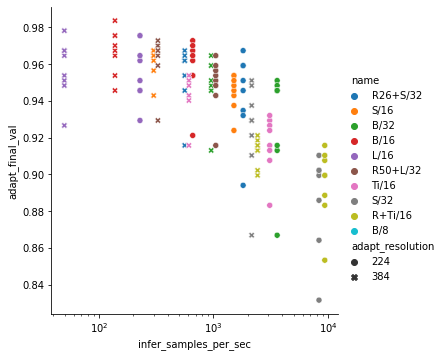

In [ ]:
# Visualize the 2 (resolution) * 9 (models) * 8 (lr, steps) finetunings for a
# single dataset (Pets37).
# Note how larger models get better scores up to B/16 @384 even on this tiny
# dataset, if pre-trained sufficiently.
sns.relplot(
    data=best_df.query('adapt_ds=="oxford_iiit_pet"'),
    x='infer_samples_per_sec',
    y='adapt_final_val',
    hue='name',
    style='adapt_resolution'
)
plt.gca().set_xscale('log');

In [ ]:
# More details for a single pre-trained checkpoint.
best_df.query('name=="B/16" and adapt_ds=="imagenet2012"')[[
  col for col in best_df.columns if col.startswith('adapt_')
]].sort_values('adapt_final_val')

,adapt_ds,adapt_lr,adapt_steps,adapt_resolution,adapt_final_val,adapt_final_test,adapt_filename
24038,imagenet2012,0.03,20000,224,0.875273,0.83332,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224
24039,imagenet2012,0.01,20000,224,0.875507,0.83962,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_224
24005,imagenet2012,0.01,20000,384,0.893771,0.86148,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.01-res_384
24004,imagenet2012,0.03,20000,384,0.894318,0.85486,B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_384


### Load a checkpoint

In [ ]:
# Select a value from "adapt_filename" above that is a fine-tuned checkpoint.
filename = 'B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224'

tfds_name = filename.split('--')[1].split('-')[0]
model_config = models_config.AUGREG_CONFIGS[filename.split('-')[0]]
resolution = int(filename.split('_')[-1])
path = f'gs://vit_models/augreg/{filename}.npz'

print(f'{tf.io.gfile.stat(path).length / 1024 / 1024:.1f} MiB - {path}')

330.3 MiB - gs://vit_models/augreg/B_16-i21k-300ep-lr_0.001-aug_medium1-wd_0.1-do_0.0-sd_0.0--imagenet2012-steps_20k-lr_0.03-res_224.npz


#### Using `timm`

If you know PyTorch, you're probably already familiar with `timm`.

If not yet - it's your lucky day! Please check out their docs here:

https://rwightman.github.io/pytorch-image-models/

In [ ]:
# Checkpoints can also be loaded directly into timm...
!pip install timm
import timm
import torch
import torch.nn.functional as nnf
import numpy as np

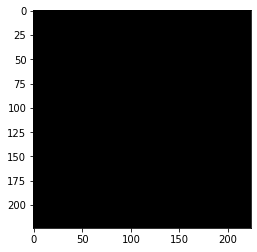

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model


In [ ]:
model_name = "vit_base_patch16_224"
device = 'cpu'
print("device = ", device)
model = timm.create_model(
    'vit_large_patch16_224', num_classes=ds_info.features['label'].num_classes)

# Non-default checkpoints need to be loaded from local files.
if not tf.io.gfile.exists(f'{filename}.npz'):
  tf.io.gfile.copy(f'gs://vit_models/augreg/{filename}.npz', f'{filename}.npz')
timm.models.load_checkpoint(timm_model, f'{filename}.npz')

device =  cpu


In [ ]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [ ]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

In [ ]:
# end-to-end inference
output = model(img_tensor)

Inference Result:
wolf_spider, hunting_spider



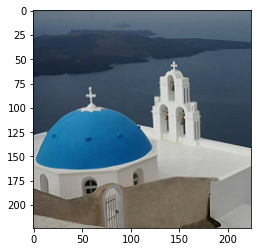

In [ ]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

In [ ]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


In [ ]:
pos_embed = model.pos_embed
print(pos_embed.shape)
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

torch.Size([1, 197, 768])
Transformer input:  torch.Size([1, 197, 768])


In [ ]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [ ]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [ ]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


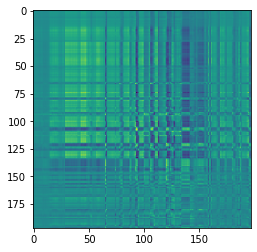

In [ ]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

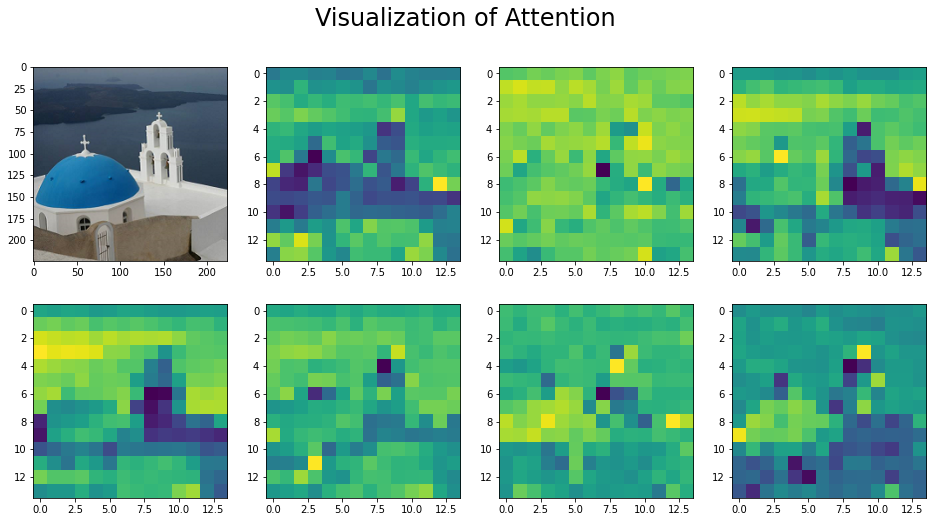

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)